In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

from sklearn import svm
import getFamaFrenchFactors as gff
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from lightgbm import plot_importance, LGBMRegressor

In [178]:
companies_df = pd.read_csv('../data/market_data/sp500/sp500_companies.csv')
index_df = pd.read_csv('../data/market_data/sp500/sp500_index.csv').set_index('Date')
stocks_df = pd.read_csv('../data/market_data/sp500/sp500_stocks.csv')
pivoted_stocks_df = stocks_df.pivot(
    index='Date', columns='Symbol', values='Adj Close')

pivoted_stocks_df = pivoted_stocks_df.reset_index()
pivoted_stocks_df['Date'] = pd.to_datetime(pivoted_stocks_df['Date'])
pivoted_stocks_df = pivoted_stocks_df.set_index('Date')

In [179]:
factors = pd.DataFrame(gff.famaFrench3Factor('m'))
# gff.famaFrench5Factor('m')
factors.head()

,date_ff_factors,Mkt-RF,SMB,HML,RF
0,1926-07-31,0.0296,-0.0256,-0.0243,0.0022
1,1926-08-31,0.0264,-0.0117,0.0382,0.0025
2,1926-09-30,0.0036,-0.0140,0.0013,0.0023
3,1926-10-31,-0.0324,-0.0009,0.0070,0.0032
4,1926-11-30,0.0253,-0.0010,-0.0051,0.0031


In [180]:
factors.shape

(1173, 5)

In [181]:
tickers = companies_df['Symbol'].unique()

In [182]:
pivoted_stocks_df.head()

Symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,20.122227,4.496877,6.470741,NaN,NaN,18.952162,7.994444,32.212460,37.090000,23.694084,...,52.883579,9.905468,41.963718,12.918809,43.185623,NaN,19.158102,52.587051,28.670000,NaN
2010-01-05,19.903643,5.005957,6.481929,NaN,NaN,18.799042,7.967778,32.411549,37.700001,23.656675,...,52.765053,10.115747,44.515926,12.765595,43.354244,NaN,19.092571,54.251759,28.620001,NaN
2010-01-06,19.832930,4.798554,6.378825,NaN,NaN,18.903446,7.933333,32.756096,37.619999,23.611784,...,53.614498,10.003899,43.932011,12.790110,43.728970,NaN,18.956089,54.234219,28.400000,NaN
2010-01-07,19.807215,4.939964,6.367033,NaN,NaN,19.060045,7.886667,32.725471,36.889999,23.424749,...,53.456463,9.959157,44.870213,12.734954,43.591564,NaN,18.950626,55.478374,27.690001,NaN
2010-01-08,19.800785,4.845691,6.409364,NaN,NaN,19.157482,7.871111,32.595306,36.689999,23.559416,...,53.397202,9.867439,44.548744,12.741086,43.416687,NaN,18.956089,54.313072,27.600000,NaN


## Lasso regression

In [183]:
pivoted_stocks_df[tickers[2]].head()

Date
2010-01-04    4.247546
2010-01-05    4.309570
2010-01-06    4.337137
2010-01-07    4.252139
2010-01-08    4.261328
Name: NVDA, dtype: float64

In [184]:
pivoted_stocks_df[tickers[2]].shape

(3611,)

ADF Statistic: -11.911264
p-value: 0.000000


<Figure size 640x480 with 0 Axes>

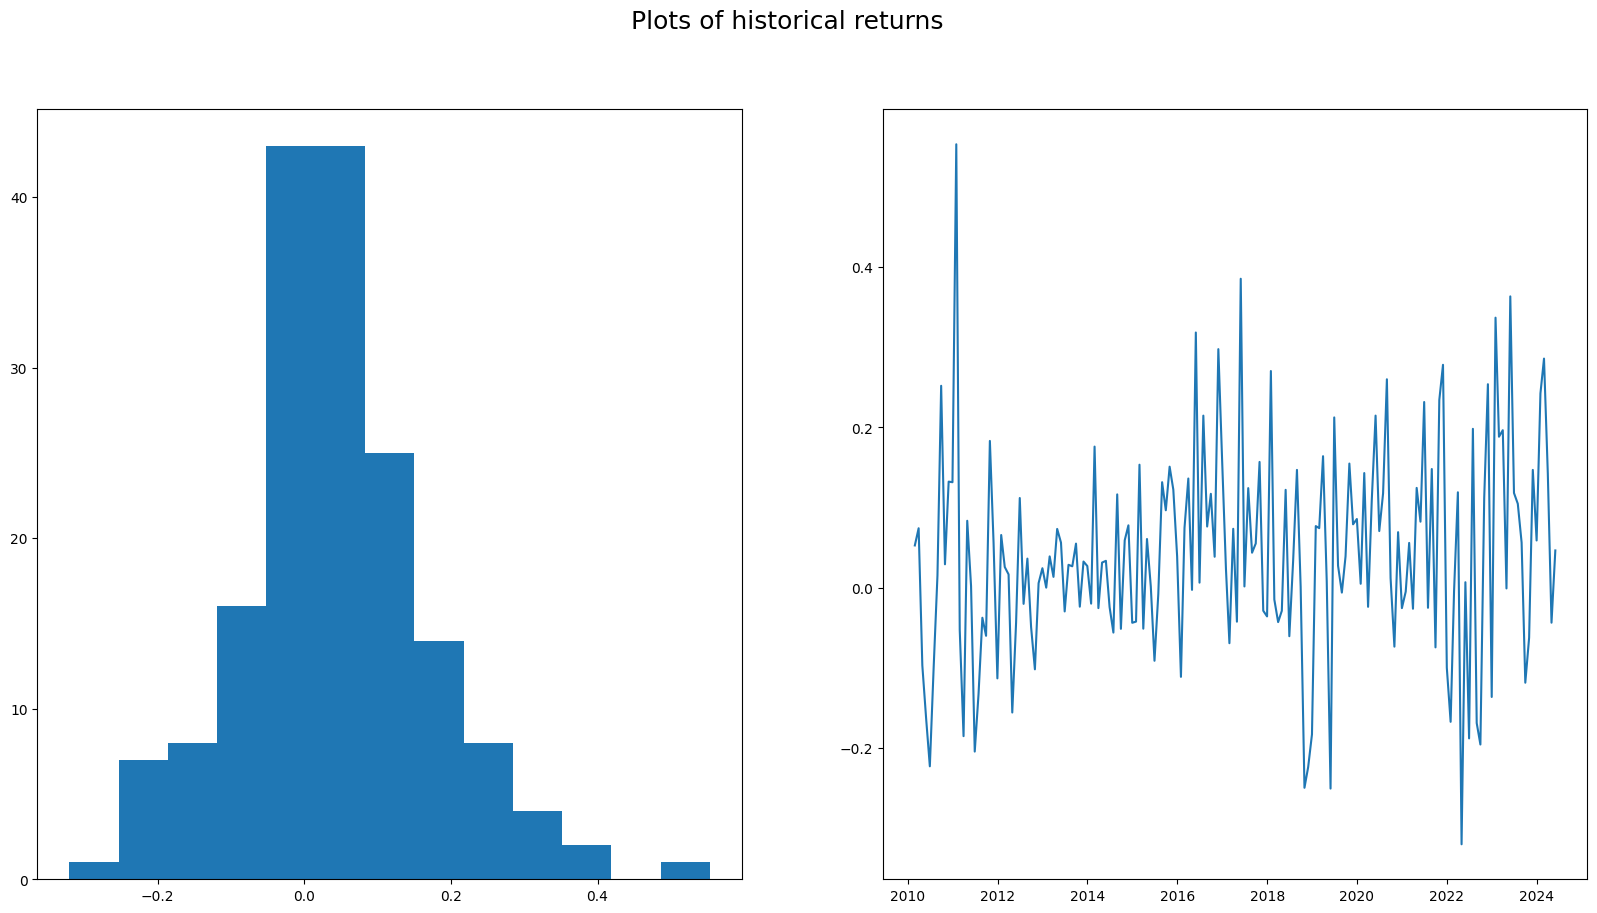

In [185]:
mon = pd.DataFrame(pivoted_stocks_df[tickers[2]]).resample('ME').last()
mon_rets = mon.pct_change().dropna()

# plots of montly rets:
plt.figure()
fig2, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].hist(mon_rets, bins=round(np.sqrt(len(mon_rets))))
axs[1].plot(mon_rets)
fig2.suptitle('Plots of historical returns', fontsize=18)

# stationarity test
adf = adfuller(mon_rets)
print('ADF Statistic: %f' % adf[0])
print('p-value: %f' % adf[1])

In [186]:
# set date columns
factors = factors.rename(columns={'date_ff_factors': 'Date'})
factors_0 = pd.merge(mon, factors, on='Date', how='left')
Y = (factors_0[tickers[2]] - factors_0['RF'])[:-2]
X = factors_0[['Mkt-RF', 'SMB', 'HML']][:-2]

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [188]:
model = Lasso(alpha=10, max_iter=1000)
model.fit(X_train, y_train)

Lasso(alpha=10)

In [189]:
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

-2.4490986338158067

## Ridge regression

## Gradient boosting

In [190]:
def objective(trial):

    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 100),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 100),
        'importance_type': trial.suggest_categorical('importance_type', ['split', 'gain']),

        'n_jobs': 12,
        'random_state': 42
    }

    regr = LGBMRegressor(**params)
    regr.fit(X, Y)
    preds = regr.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    return mse

In [191]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-05-10 06:02:45,603] A new study created in memory with name: no-name-bbf524bd-0fd7-4e29-b57f-6b14942ffd37
[I 2024-05-10 06:02:45,705] Trial 0 finished with value: 80654.32337546578 and parameters: {'learning_rate': 0.010787893272927517, 'num_leaves': 80, 'n_estimators': 186, 'max_depth': 12, 'min_data_in_leaf': 50, 'feature_fraction': 0.623404340170181, 'subsample': 0.9934385060693083, 'lambda_l1': 76.44931484930433, 'lambda_l2': 93.94542848068464, 'importance_type': 'split'}. Best is trial 0 with value: 80654.32337546578.
[I 2024-05-10 06:02:45,795] Trial 1 finished with value: 76588.66935257448 and parameters: {'learning_rate': 0.016527198997351156, 'num_leaves': 13, 'n_estimators': 130, 'max_depth': 20, 'min_data_in_leaf': 38, 'feature_fraction': 0.7830693013561544, 'subsample': 0.2377567964929541, 'lambda_l1': 33.30156190668806, 'lambda_l2': 36.08833449785293, 'importance_type': 'gain'}. Best is trial 1 with value: 76588.66935257448.


[LightGBM] [Warning] lambda_l1 is set=76.44931484930433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=76.44931484930433
[LightGBM] [Warning] feature_fraction is set=0.623404340170181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.623404340170181
[LightGBM] [Warning] lambda_l2 is set=93.94542848068464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=93.94542848068464
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=76.44931484930433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=76.44931484930433
[LightGBM] [Warning] feature_fraction is set=0.623404340170181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.623404340170181
[LightGBM] [Warning] lambda_l2 is set=93.94542848068464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=93.94542848068464
[LightGBM] [Warning] min_data_in_leaf is set=50,

[I 2024-05-10 06:02:45,832] Trial 2 finished with value: 67191.66920198406 and parameters: {'learning_rate': 0.255927282642158, 'num_leaves': 39, 'n_estimators': 50, 'max_depth': 4, 'min_data_in_leaf': 41, 'feature_fraction': 0.8300820031117665, 'subsample': 0.2906527166279137, 'lambda_l1': 43.71319332981762, 'lambda_l2': 27.71669888353766, 'importance_type': 'gain'}. Best is trial 2 with value: 67191.66920198406.
[I 2024-05-10 06:02:45,863] Trial 3 finished with value: 76800.54945831273 and parameters: {'learning_rate': 0.33008381113369767, 'num_leaves': 99, 'n_estimators': 59, 'max_depth': 90, 'min_data_in_leaf': 67, 'feature_fraction': 0.6371807351409772, 'subsample': 0.8208070357127051, 'lambda_l1': 68.02678179572882, 'lambda_l2': 84.24769769362773, 'importance_type': 'split'}. Best is trial 2 with value: 67191.66920198406.
[I 2024-05-10 06:02:45,869] Trial 4 finished with value: 83569.41165428243 and parameters: {'learning_rate': 0.17316019122474513, 'num_leaves': 58, 'n_estimator

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:46,053] Trial 6 finished with value: 68116.57955964525 and parameters: {'learning_rate': 0.030140367870038823, 'num_leaves': 63, 'n_estimators': 148, 'max_depth': 51, 'min_data_in_leaf': 19, 'feature_fraction': 0.6232923063117354, 'subsample': 0.3373206433935506, 'lambda_l1': 78.78572965687492, 'lambda_l2': 43.80335304757188, 'importance_type': 'split'}. Best is trial 2 with value: 67191.66920198406.
[I 2024-05-10 06:02:46,077] Trial 7 finished with value: 82919.94925718383 and parameters: {'learning_rate': 0.010503758940436281, 'num_leaves': 90, 'n_estimators': 28, 'max_depth': 42, 'min_data_in_leaf': 39, 'feature_fraction': 0.20195220677509668, 'subsample': 0.5467513142689857, 'lambda_l1': 32.165754470910244, 'lambda_l2': 81.13322920161654, 'importance_type': 'split'}. Best is trial 2 with value: 67191.66920198406.
[I 2024-05-10 06:02:46,090] Trial 8 finished with value: 83569.41165428243 and parameters: {'learning_rate': 0.15822452632377634, 'num_leaves': 45, 'n_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:46,289] Trial 11 finished with value: 2884.461987690981 and parameters: {'learning_rate': 0.8628938684738995, 'num_leaves': 34, 'n_estimators': 106, 'max_depth': 3, 'min_data_in_leaf': 11, 'feature_fraction': 0.9980297614940049, 'subsample': 0.4130029858730551, 'lambda_l1': 1.6833992858294096, 'lambda_l2': 0.9646023027179602, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.
[I 2024-05-10 06:02:46,390] Trial 12 finished with value: 5111.174948281325 and parameters: {'learning_rate': 0.9135775251255154, 'num_leaves': 23, 'n_estimators': 107, 'max_depth': 3, 'min_data_in_leaf': 17, 'feature_fraction': 0.9885910898351575, 'subsample': 0.45838076109050735, 'lambda_l1': 3.8692085852777147, 'lambda_l2': 1.824785928854578, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:46,509] Trial 13 finished with value: 5866.13323247025 and parameters: {'learning_rate': 0.9044167558155404, 'num_leaves': 18, 'n_estimators': 108, 'max_depth': 72, 'min_data_in_leaf': 23, 'feature_fraction': 0.9996633636884853, 'subsample': 0.4852190220073492, 'lambda_l1': 3.07837180832027, 'lambda_l2': 0.23721354139424156, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:46,626] Trial 14 finished with value: 11407.97425315984 and parameters: {'learning_rate': 0.4750364736563096, 'num_leaves': 28, 'n_estimators': 167, 'max_depth': 62, 'min_data_in_leaf': 26, 'feature_fraction': 0.8411013827606305, 'subsample': 0.620272285104956, 'lambda_l1': 2.546467414390514, 'lambda_l2': 0.8670275833866066, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.
[I 2024-05-10 06:02:46,793] Trial 15 finished with value: 61313.17639901936 and parameters: {'learning_rate': 0.05108837996237712, 'num_leaves': 25, 'n_estimators': 109, 'max_depth': 10, 'min_data_in_leaf': 13, 'feature_fraction': 0.900685050996268, 'subsample': 0.10055886017812304, 'lambda_l1': 14.424827864215725, 'lambda_l2': 63.527722522233205, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=2.546467414390514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.546467414390514
[LightGBM] [Warning] feature_fraction is set=0.8411013827606305, colsample_bytree=1.0 will be ignored. Current value: f

[I 2024-05-10 06:02:46,888] Trial 16 finished with value: 38356.31704311964 and parameters: {'learning_rate': 0.5300982975116854, 'num_leaves': 47, 'n_estimators': 84, 'max_depth': 92, 'min_data_in_leaf': 29, 'feature_fraction': 0.7376966452705185, 'subsample': 0.4102777358363924, 'lambda_l1': 15.44204403645382, 'lambda_l2': 13.757343462735706, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.
[I 2024-05-10 06:02:46,954] Trial 17 finished with value: 68614.7439076814 and parameters: {'learning_rate': 0.5491147454780547, 'num_leaves': 11, 'n_estimators': 131, 'max_depth': 32, 'min_data_in_leaf': 61, 'feature_fraction': 0.4420239177114099, 'subsample': 0.6866981890950484, 'lambda_l1': 1.5944804498281187, 'lambda_l2': 10.570456164269707, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:47,314] Trial 18 finished with value: 6624.60088289786 and parameters: {'learning_rate': 0.9902140686439243, 'num_leaves': 26, 'n_estimators': 160, 'max_depth': 16, 'min_data_in_leaf': 10, 'feature_fraction': 0.9147822765382833, 'subsample': 0.45812501788628823, 'lambda_l1': 99.00321782954754, 'lambda_l2': 59.66183639752505, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.
[I 2024-05-10 06:02:47,365] Trial 19 finished with value: 74974.70523361333 and parameters: {'learning_rate': 0.06613987925131491, 'num_leaves': 47, 'n_estimators': 69, 'max_depth': 79, 'min_data_in_leaf': 48, 'feature_fraction': 0.7223412594747454, 'subsample': 0.34459739210765283, 'lambda_l1': 22.41971123346352, 'lambda_l2': 30.871973952728588, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:47,477] Trial 20 finished with value: 32620.98013333729 and parameters: {'learning_rate': 0.32484631042519574, 'num_leaves': 34, 'n_estimators': 123, 'max_depth': 55, 'min_data_in_leaf': 30, 'feature_fraction': 0.9169819357528265, 'subsample': 0.5464993820773428, 'lambda_l1': 46.80069507929942, 'lambda_l2': 8.75691353462009, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.
[I 2024-05-10 06:02:47,599] Trial 21 finished with value: 7612.8323803395115 and parameters: {'learning_rate': 0.7135294705901261, 'num_leaves': 18, 'n_estimators': 96, 'max_depth': 71, 'min_data_in_leaf': 21, 'feature_fraction': 0.9801111945925732, 'subsample': 0.4750449000866202, 'lambda_l1': 7.027801221177332, 'lambda_l2': 1.0199856500816273, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:47,758] Trial 22 finished with value: 5812.862584242044 and parameters: {'learning_rate': 0.9467615108935801, 'num_leaves': 19, 'n_estimators': 113, 'max_depth': 80, 'min_data_in_leaf': 18, 'feature_fraction': 0.9751449588961404, 'subsample': 0.494435018077771, 'lambda_l1': 9.6010414031756, 'lambda_l2': 19.64602420751803, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:47,950] Trial 23 finished with value: 10359.044422221275 and parameters: {'learning_rate': 0.48577314052313253, 'num_leaves': 23, 'n_estimators': 118, 'max_depth': 100, 'min_data_in_leaf': 15, 'feature_fraction': 0.8873634691660452, 'subsample': 0.6925726463701919, 'lambda_l1': 11.508874667236974, 'lambda_l2': 19.7099949500891, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:48,036] Trial 24 finished with value: 37192.62998830143 and parameters: {'learning_rate': 0.6488574222825207, 'num_leaves': 31, 'n_estimators': 97, 'max_depth': 40, 'min_data_in_leaf': 32, 'feature_fraction': 0.7821778901743408, 'subsample': 0.39240125619350347, 'lambda_l1': 22.788446065929666, 'lambda_l2': 7.954184300119383, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=22.788446065929666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=22.788446065929666
[LightGBM] [Warning] feature_fraction is s

[I 2024-05-10 06:02:48,242] Trial 25 finished with value: 26134.41395272291 and parameters: {'learning_rate': 0.32984833029848676, 'num_leaves': 19, 'n_estimators': 159, 'max_depth': 9, 'min_data_in_leaf': 21, 'feature_fraction': 0.9390077289494243, 'subsample': 0.6047633918594418, 'lambda_l1': 39.1104989247564, 'lambda_l2': 36.782361193257515, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=39.1104989247564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=39.1104989247564
[LightGBM] [Warning] feature_fraction is set=0.9390077289494243, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2024-05-10 06:02:48,487] Trial 26 finished with value: 23138.92435057311 and parameters: {'learning_rate': 0.24611227288443083, 'num_leaves': 40, 'n_estimators': 198, 'max_depth': 59, 'min_data_in_leaf': 18, 'feature_fraction': 0.824391346999353, 'subsample': 0.22013172929340624, 'lambda_l1': 21.607235033369736, 'lambda_l2': 20.272563489094306, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.
[I 2024-05-10 06:02:48,549] Trial 27 finished with value: 71249.74291624507 and parameters: {'learning_rate': 0.4248592339352546, 'num_leaves': 52, 'n_estimators': 143, 'max_depth': 80, 'min_data_in_leaf': 72, 'feature_fraction': 0.9999648146239493, 'subsample': 0.501493191819779, 'lambda_l1': 11.035786393934629, 'lambda_l2': 7.463179606607088, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.
[I 2024-05-10 06:02:48,606] Trial 28 finished with value: 57814.11382309653 and parameters: {'learning_rate': 0.9923559077908989, 'num_leaves': 10, 'n_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:48,703] Trial 29 finished with value: 55973.36753343064 and parameters: {'learning_rate': 0.7166249318237639, 'num_leaves': 40, 'n_estimators': 175, 'max_depth': 14, 'min_data_in_leaf': 48, 'feature_fraction': 0.4834987755343434, 'subsample': 0.705793075161157, 'lambda_l1': 1.3553825744803607, 'lambda_l2': 14.212707239653227, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.
[I 2024-05-10 06:02:48,721] Trial 30 finished with value: 83569.41165428243 and parameters: {'learning_rate': 0.6762327062746489, 'num_leaves': 19, 'n_estimators': 15, 'max_depth': 23, 'min_data_in_leaf': 98, 'feature_fraction': 0.8573027356616789, 'subsample': 0.4250500913666202, 'lambda_l1': 19.557466450449873, 'lambda_l2': 5.288040339504283, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.
[I 2024-05-10 06:02:48,825] Trial 31 finished with value: 7191.136635650283 and parameters: {'learning_rate': 0.8338301510275724, 'num_leaves': 16, 'n_es

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:48,929] Trial 32 finished with value: 13121.78055492943 and parameters: {'learning_rate': 0.9529488081064554, 'num_leaves': 22, 'n_estimators': 111, 'max_depth': 79, 'min_data_in_leaf': 26, 'feature_fraction': 0.9969469981948744, 'subsample': 0.556875423486116, 'lambda_l1': 1.6598464953749006, 'lambda_l2': 17.464503475284882, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] lambda_l1 is set=1.6598464953749006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6598464953749006
[LightGBM] [Warning] feature_fraction is set=0.9969469981948744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9969469981948744
[LightGBM] [Warning] lambda_l2 is set=17.464503475284882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.464503475284882
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l1 is set=1.6598464953749006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6598464953749006
[LightGBM] [Warning] feature_fraction is set=0.9969469981948744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9969469981948744
[LightGBM] [Warning] lambda_l2 is set=17.464503475284882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.464503475284882
[LightGBM] [Warning] min_data_in_lea

[I 2024-05-10 06:02:49,042] Trial 33 finished with value: 73159.77620257146 and parameters: {'learning_rate': 0.01815407567804147, 'num_leaves': 29, 'n_estimators': 92, 'max_depth': 69, 'min_data_in_leaf': 16, 'feature_fraction': 0.7924837842951638, 'subsample': 0.2480122580255827, 'lambda_l1': 28.44692657800444, 'lambda_l2': 31.252833479602884, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.
[I 2024-05-10 06:02:49,082] Trial 34 finished with value: 70599.0667549444 and parameters: {'learning_rate': 0.4081968436749616, 'num_leaves': 14, 'n_estimators': 71, 'max_depth': 88, 'min_data_in_leaf': 55, 'feature_fraction': 0.8828738312508331, 'subsample': 0.375778723804642, 'lambda_l1': 8.219080434840713, 'lambda_l2': 23.677242488661555, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] lambda_l1 is set=8.219080434840713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.219080434840713
[LightGBM] [Warning] feature_fraction is set=0.8828738312508331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8828738312508331
[LightGBM] [Warning] lambda_l2 is set=23.677242488661555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.677242488661555
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] lambda_l1 is set=8.219080434840713, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.219080434840713
[LightGBM] [Warning] feature_fraction is set=0.8828738312508331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8828738312508331
[LightGBM] [Warning] lambda_l2 is set=23.677242488661555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.677242488661555
[LightGBM] [Warning] min_data_in_leaf is

[I 2024-05-10 06:02:49,338] Trial 35 finished with value: 7560.359699021475 and parameters: {'learning_rate': 0.23058575287398253, 'num_leaves': 35, 'n_estimators': 133, 'max_depth': 7, 'min_data_in_leaf': 10, 'feature_fraction': 0.921559535798125, 'subsample': 0.4584381938805685, 'lambda_l1': 54.260786330624356, 'lambda_l2': 4.739124296246188, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.
[I 2024-05-10 06:02:49,384] Trial 36 finished with value: 53786.818693947025 and parameters: {'learning_rate': 0.5978074903850804, 'num_leaves': 22, 'n_estimators': 55, 'max_depth': 76, 'min_data_in_leaf': 40, 'feature_fraction': 0.9573674573447764, 'subsample': 0.5708686550615054, 'lambda_l1': 0.8932655998631687, 'lambda_l2': 11.908282916115908, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:49,464] Trial 37 finished with value: 60297.03330584598 and parameters: {'learning_rate': 0.37913000969540855, 'num_leaves': 72, 'n_estimators': 123, 'max_depth': 36, 'min_data_in_leaf': 44, 'feature_fraction': 0.6706562790185295, 'subsample': 0.25241323579082947, 'lambda_l1': 37.75936055685591, 'lambda_l2': 23.678800714149038, 'importance_type': 'split'}. Best is trial 11 with value: 2884.461987690981.
[I 2024-05-10 06:02:49,574] Trial 38 finished with value: 26916.25273740653 and parameters: {'learning_rate': 0.7397622476206112, 'num_leaves': 15, 'n_estimators': 109, 'max_depth': 88, 'min_data_in_leaf': 24, 'feature_fraction': 0.7867213818537494, 'subsample': 0.28865048594632864, 'lambda_l1': 16.70592794529434, 'lambda_l2': 35.4663183887176, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] lambda_l1 is set=37.75936055685591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=37.75936055685591
[LightGBM] [Warning] feature_fraction is set=0.6706562790185295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6706562790185295
[LightGBM] [Warning] lambda_l2 is set=23.678800714149038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.678800714149038
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] lambda_l1 is set=16.70592794529434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16.70592794529434
[LightGBM] [Warning] feature_fraction is set=0.7867213818537494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7867213818537494
[LightGBM] [Warning] lambda_l2 is set=35.4663183887176, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.4663183887176
[LightGBM] [Warning] min_data_in_leaf is set

[I 2024-05-10 06:02:49,687] Trial 39 finished with value: 41694.73659904389 and parameters: {'learning_rate': 0.2137948601927763, 'num_leaves': 31, 'n_estimators': 153, 'max_depth': 98, 'min_data_in_leaf': 34, 'feature_fraction': 0.8559135226841347, 'subsample': 0.6489629038117642, 'lambda_l1': 27.381481239895777, 'lambda_l2': 5.073134465317592, 'importance_type': 'split'}. Best is trial 11 with value: 2884.461987690981.
[I 2024-05-10 06:02:49,817] Trial 40 finished with value: 7299.8259770550485 and parameters: {'learning_rate': 0.596214131344426, 'num_leaves': 58, 'n_estimators': 82, 'max_depth': 46, 'min_data_in_leaf': 15, 'feature_fraction': 0.5626197772277888, 'subsample': 0.7546161801954214, 'lambda_l1': 5.381255214046204, 'lambda_l2': 0.19737517233440305, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:49,932] Trial 41 finished with value: 17270.86145833453 and parameters: {'learning_rate': 0.9550425643383466, 'num_leaves': 26, 'n_estimators': 65, 'max_depth': 16, 'min_data_in_leaf': 11, 'feature_fraction': 0.940920335810925, 'subsample': 0.4445584558596564, 'lambda_l1': 96.52317379193802, 'lambda_l2': 67.00397696236796, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:50,145] Trial 42 finished with value: 9906.937459125116 and parameters: {'learning_rate': 0.9782590924132668, 'num_leaves': 21, 'n_estimators': 186, 'max_depth': 16, 'min_data_in_leaf': 18, 'feature_fraction': 0.9995776633381126, 'subsample': 0.4851160239043346, 'lambda_l1': 75.59061214165496, 'lambda_l2': 56.36589155257813, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:50,404] Trial 43 finished with value: 6040.602833882978 and parameters: {'learning_rate': 0.764490110811832, 'num_leaves': 35, 'n_estimators': 142, 'max_depth': 22, 'min_data_in_leaf': 10, 'feature_fraction': 0.8983802454169529, 'subsample': 0.5342519670830758, 'lambda_l1': 61.72081967889111, 'lambda_l2': 44.35630164199082, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:50,530] Trial 44 finished with value: 53394.18360099797 and parameters: {'learning_rate': 0.11138148299361085, 'num_leaves': 42, 'n_estimators': 140, 'max_depth': 4, 'min_data_in_leaf': 27, 'feature_fraction': 0.95191666760612, 'subsample': 0.5198906324761153, 'lambda_l1': 57.68534438840251, 'lambda_l2': 42.359288789644935, 'importance_type': 'split'}. Best is trial 11 with value: 2884.461987690981.
[I 2024-05-10 06:02:50,648] Trial 45 finished with value: 17417.317490309768 and parameters: {'learning_rate': 0.7836406092946245, 'num_leaves': 34, 'n_estimators': 129, 'max_depth': 21, 'min_data_in_leaf': 19, 'feature_fraction': 0.8851308297406563, 'subsample': 0.35974859555199273, 'lambda_l1': 67.79321325775356, 'lambda_l2': 49.429963195773084, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:50,792] Trial 46 finished with value: 29500.514213922026 and parameters: {'learning_rate': 0.3075948083324696, 'num_leaves': 65, 'n_estimators': 101, 'max_depth': 25, 'min_data_in_leaf': 14, 'feature_fraction': 0.8226980167363682, 'subsample': 0.5884578101962464, 'lambda_l1': 59.602895108105415, 'lambda_l2': 27.95201238233836, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:50,893] Trial 47 finished with value: 51196.27145290683 and parameters: {'learning_rate': 0.4913642409627529, 'num_leaves': 13, 'n_estimators': 115, 'max_depth': 4, 'min_data_in_leaf': 24, 'feature_fraction': 0.3556851280885851, 'subsample': 0.5304438378613506, 'lambda_l1': 12.922865798584041, 'lambda_l2': 86.37407900344694, 'importance_type': 'split'}. Best is trial 11 with value: 2884.461987690981.
[I 2024-05-10 06:02:51,025] Trial 48 finished with value: 59069.885630737524 and parameters: {'learning_rate': 0.031427276048588, 'num_leaves': 28, 'n_estimators': 89, 'max_depth': 61, 'min_data_in_leaf': 14, 'feature_fraction': 0.8833939830670285, 'subsample': 0.41399666875723606, 'lambda_l1': 63.33095211136409, 'lambda_l2': 12.30528732155338, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.
[I 2024-05-10 06:02:51,069] Trial 49 finished with value: 57380.27679570465 and parameters: {'learning_rate': 0.5515676547343366, 'num_leaves': 44, 'n_es

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:51,172] Trial 50 finished with value: 17816.926753189728 and parameters: {'learning_rate': 0.7808493607853999, 'num_leaves': 36, 'n_estimators': 127, 'max_depth': 84, 'min_data_in_leaf': 30, 'feature_fraction': 0.9195173449045169, 'subsample': 0.9818038156948683, 'lambda_l1': 79.83554990080107, 'lambda_l2': 4.089427866260185, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] lambda_l1 is set=79.83554990080107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=79.83554990080107
[LightGBM] [Warning] feature_fraction is set=0.9195173449045169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9195173449045169
[LightGBM] [Warning] lambda_l2 is set=4.089427866260185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.089427866260185
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=79.83554990080107, reg_alpha=0.0 will be ignored. Current value: lambda_l1=79.83554990080107
[LightGBM] [Warning] feature_fraction is set=0.9195173449045169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9195173449045169
[LightGBM] [Warning] lambda_l2 is set=4.089427866260185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.089427866260185
[LightGBM] [Warning] min_data_in_leaf is set

[I 2024-05-10 06:02:51,462] Trial 51 finished with value: 8087.4181562548765 and parameters: {'learning_rate': 0.8060957376959912, 'num_leaves': 26, 'n_estimators': 164, 'max_depth': 18, 'min_data_in_leaf': 10, 'feature_fraction': 0.9132133697711741, 'subsample': 0.4514900499491437, 'lambda_l1': 85.82274350372016, 'lambda_l2': 70.953768891958, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:51,640] Trial 52 finished with value: 15905.13162298071 and parameters: {'learning_rate': 0.9893953480831077, 'num_leaves': 24, 'n_estimators': 148, 'max_depth': 12, 'min_data_in_leaf': 20, 'feature_fraction': 0.9730082831178809, 'subsample': 0.6445275651095872, 'lambda_l1': 99.34784252811303, 'lambda_l2': 56.71298042997016, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:51,948] Trial 53 finished with value: 9143.257727861877 and parameters: {'learning_rate': 0.6365677533654306, 'num_leaves': 31, 'n_estimators': 176, 'max_depth': 7, 'min_data_in_leaf': 10, 'feature_fraction': 0.8548028134374164, 'subsample': 0.48022226964862963, 'lambda_l1': 90.59486948820523, 'lambda_l2': 61.74505277139046, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.
[I 2024-05-10 06:02:52,067] Trial 54 finished with value: 38954.05912726459 and parameters: {'learning_rate': 0.8250826109787046, 'num_leaves': 17, 'n_estimators': 106, 'max_depth': 28, 'min_data_in_leaf': 17, 'feature_fraction': 0.12613816498692382, 'subsample': 0.4348153748309939, 'lambda_l1': 49.663785785435756, 'lambda_l2': 50.86582353091906, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:52,285] Trial 55 finished with value: 6988.413105655815 and parameters: {'learning_rate': 0.4626239021825744, 'num_leaves': 85, 'n_estimators': 134, 'max_depth': 47, 'min_data_in_leaf': 13, 'feature_fraction': 0.7528935310096132, 'subsample': 0.38931969288937834, 'lambda_l1': 3.948350209523012, 'lambda_l2': 8.982256548272188, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:52,443] Trial 56 finished with value: 48417.02114178918 and parameters: {'learning_rate': 0.13229298860021851, 'num_leaves': 20, 'n_estimators': 153, 'max_depth': 72, 'min_data_in_leaf': 21, 'feature_fraction': 0.9704705740937537, 'subsample': 0.5265390407846375, 'lambda_l1': 11.40359384866145, 'lambda_l2': 74.05232883733177, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.
[I 2024-05-10 06:02:52,486] Trial 57 finished with value: 78076.64548907873 and parameters: {'learning_rate': 0.062260926346844936, 'num_leaves': 11, 'n_estimators': 80, 'max_depth': 34, 'min_data_in_leaf': 72, 'feature_fraction': 0.9145253326736306, 'subsample': 0.33283939393257406, 'lambda_l1': 34.75132845613379, 'lambda_l2': 16.98154444654869, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] lambda_l1 is set=11.40359384866145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=11.40359384866145
[LightGBM] [Warning] feature_fraction is set=0.9704705740937537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9704705740937537
[LightGBM] [Warning] lambda_l2 is set=74.05232883733177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.05232883733177
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] lambda_l1 is set=11.40359384866145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=11.40359384866145
[LightGBM] [Warning] feature_fraction is set=0.9704705740937537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9704705740937537
[LightGBM] [Warning] lambda_l2 is set=74.05232883733177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.05232883733177
[LightGBM] [Warning] min_data_in_leaf is set

[I 2024-05-10 06:02:52,659] Trial 58 finished with value: 17155.780454522253 and parameters: {'learning_rate': 0.5566636531975627, 'num_leaves': 26, 'n_estimators': 116, 'max_depth': 6, 'min_data_in_leaf': 13, 'feature_fraction': 0.8067682121301579, 'subsample': 0.5887576197051281, 'lambda_l1': 41.65823070511597, 'lambda_l2': 38.36101117911526, 'importance_type': 'split'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:52,754] Trial 59 finished with value: 40013.58619902623 and parameters: {'learning_rate': 0.3648918889375222, 'num_leaves': 36, 'n_estimators': 104, 'max_depth': 94, 'min_data_in_leaf': 28, 'feature_fraction': 0.8698409298598102, 'subsample': 0.47372336102634516, 'lambda_l1': 18.44857668875373, 'lambda_l2': 46.65182217203497, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.
[I 2024-05-10 06:02:52,814] Trial 60 finished with value: 54477.52745749832 and parameters: {'learning_rate': 0.6696569594200509, 'num_leaves': 32, 'n_estimators': 141, 'max_depth': 1, 'min_data_in_leaf': 23, 'feature_fraction': 0.9361867716489441, 'subsample': 0.558404230859278, 'lambda_l1': 9.961700205226709, 'lambda_l2': 19.96436447506428, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:53,010] Trial 61 finished with value: 7687.441614394101 and parameters: {'learning_rate': 0.4824327935554853, 'num_leaves': 53, 'n_estimators': 131, 'max_depth': 55, 'min_data_in_leaf': 14, 'feature_fraction': 0.7438042786340925, 'subsample': 0.3854466093451022, 'lambda_l1': 4.8076068542064, 'lambda_l2': 9.19134554510352, 'importance_type': 'gain'}. Best is trial 11 with value: 2884.461987690981.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:53,196] Trial 62 finished with value: 2631.754225508127 and parameters: {'learning_rate': 0.8577409974443057, 'num_leaves': 81, 'n_estimators': 148, 'max_depth': 66, 'min_data_in_leaf': 18, 'feature_fraction': 0.9750962898576717, 'subsample': 0.39990131142590546, 'lambda_l1': 4.1456340829053655, 'lambda_l2': 3.51554633442083, 'importance_type': 'gain'}. Best is trial 62 with value: 2631.754225508127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:53,405] Trial 63 finished with value: 2287.8520907536595 and parameters: {'learning_rate': 0.8920128763542337, 'num_leaves': 79, 'n_estimators': 168, 'max_depth': 66, 'min_data_in_leaf': 18, 'feature_fraction': 0.9780341021893686, 'subsample': 0.503863570347098, 'lambda_l1': 4.901390448218785, 'lambda_l2': 2.9490646666285523, 'importance_type': 'gain'}. Best is trial 63 with value: 2287.8520907536595.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:53,633] Trial 64 finished with value: 1829.2439042092385 and parameters: {'learning_rate': 0.8850341720563937, 'num_leaves': 80, 'n_estimators': 176, 'max_depth': 64, 'min_data_in_leaf': 17, 'feature_fraction': 0.9965237983026026, 'subsample': 0.42368214373464597, 'lambda_l1': 0.5842270424177594, 'lambda_l2': 2.2419696460727527, 'importance_type': 'gain'}. Best is trial 64 with value: 1829.2439042092385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:53,877] Trial 65 finished with value: 2006.2395317999983 and parameters: {'learning_rate': 0.860826119419396, 'num_leaves': 75, 'n_estimators': 198, 'max_depth': 65, 'min_data_in_leaf': 18, 'feature_fraction': 0.9808961794809632, 'subsample': 0.43129315599032475, 'lambda_l1': 0.40121260104677225, 'lambda_l2': 3.3100661594179357, 'importance_type': 'gain'}. Best is trial 64 with value: 1829.2439042092385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:54,122] Trial 66 finished with value: 2083.181915980127 and parameters: {'learning_rate': 0.8648729858117511, 'num_leaves': 79, 'n_estimators': 192, 'max_depth': 66, 'min_data_in_leaf': 17, 'feature_fraction': 0.9616234231873116, 'subsample': 0.42281744379704334, 'lambda_l1': 14.401605530830595, 'lambda_l2': 3.612944934572101, 'importance_type': 'gain'}. Best is trial 64 with value: 1829.2439042092385.
[I 2024-05-10 06:02:54,313] Trial 67 finished with value: 7791.40012688207 and parameters: {'learning_rate': 0.6508490088879464, 'num_leaves': 78, 'n_estimators': 198, 'max_depth': 67, 'min_data_in_leaf': 26, 'feature_fraction': 0.9792773518642098, 'subsample': 0.3561818024244098, 'lambda_l1': 14.839125409874097, 'lambda_l2': 3.0014156035115387, 'importance_type': 'gain'}. Best is trial 64 with value: 1829.2439042092385.


[LightGBM] [Warning] lambda_l1 is set=14.401605530830595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14.401605530830595
[LightGBM] [Warning] feature_fraction is set=0.9616234231873116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9616234231873116
[LightGBM] [Warning] lambda_l2 is set=3.612944934572101, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.612944934572101
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] lambda_l1 is set=14.839125409874097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14.839125409874097
[LightGBM] [Warning] feature_fraction is set=0.9792773518642098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9792773518642098
[LightGBM] [Warning] lambda_l2 is set=3.0014156035115387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0014156035115387
[LightGBM] [Warning] min_data_in_leaf 

[I 2024-05-10 06:02:54,560] Trial 68 finished with value: 2263.0417378673405 and parameters: {'learning_rate': 0.8418451803163141, 'num_leaves': 93, 'n_estimators': 189, 'max_depth': 64, 'min_data_in_leaf': 17, 'feature_fraction': 0.9460924938922863, 'subsample': 0.42105015024681053, 'lambda_l1': 5.715949632266882, 'lambda_l2': 6.7608457643649515, 'importance_type': 'gain'}. Best is trial 64 with value: 1829.2439042092385.
[I 2024-05-10 06:02:54,697] Trial 69 finished with value: 30120.284653974006 and parameters: {'learning_rate': 0.29569571034448944, 'num_leaves': 93, 'n_estimators': 190, 'max_depth': 65, 'min_data_in_leaf': 32, 'feature_fraction': 0.9414302792339038, 'subsample': 0.40835773184872903, 'lambda_l1': 0.11276777456806775, 'lambda_l2': 6.966747404268596, 'importance_type': 'gain'}. Best is trial 64 with value: 1829.2439042092385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:54,874] Trial 70 finished with value: 5762.965994341485 and parameters: {'learning_rate': 0.8363143091098441, 'num_leaves': 83, 'n_estimators': 175, 'max_depth': 52, 'min_data_in_leaf': 22, 'feature_fraction': 0.9675939812126113, 'subsample': 0.4271290329400687, 'lambda_l1': 6.5333632053367365, 'lambda_l2': 14.3224900554587, 'importance_type': 'gain'}. Best is trial 64 with value: 1829.2439042092385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:55,117] Trial 71 finished with value: 1882.1063696755436 and parameters: {'learning_rate': 0.8433782427972916, 'num_leaves': 75, 'n_estimators': 187, 'max_depth': 58, 'min_data_in_leaf': 17, 'feature_fraction': 0.980788124133631, 'subsample': 0.31644563753546817, 'lambda_l1': 5.048890631042541, 'lambda_l2': 2.2667051744828495, 'importance_type': 'gain'}. Best is trial 64 with value: 1829.2439042092385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:55,424] Trial 72 finished with value: 3394.487508067315 and parameters: {'learning_rate': 0.7078614183490542, 'num_leaves': 76, 'n_estimators': 184, 'max_depth': 57, 'min_data_in_leaf': 19, 'feature_fraction': 0.9980080445699083, 'subsample': 0.30260438236711024, 'lambda_l1': 3.968860948816197, 'lambda_l2': 3.345269052474377, 'importance_type': 'gain'}. Best is trial 64 with value: 1829.2439042092385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:55,672] Trial 73 finished with value: 3331.797288240016 and parameters: {'learning_rate': 0.5805563382003973, 'num_leaves': 85, 'n_estimators': 170, 'max_depth': 62, 'min_data_in_leaf': 15, 'feature_fraction': 0.9297227171744316, 'subsample': 0.33658453542134487, 'lambda_l1': 0.0754855268307919, 'lambda_l2': 10.486440874432311, 'importance_type': 'gain'}. Best is trial 64 with value: 1829.2439042092385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:55,921] Trial 74 finished with value: 2152.483890029765 and parameters: {'learning_rate': 0.8724685117077843, 'num_leaves': 99, 'n_estimators': 191, 'max_depth': 75, 'min_data_in_leaf': 17, 'feature_fraction': 0.9526071420683746, 'subsample': 0.37014532167078334, 'lambda_l1': 9.016733703536804, 'lambda_l2': 6.275364381667173, 'importance_type': 'gain'}. Best is trial 64 with value: 1829.2439042092385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:56,178] Trial 75 finished with value: 2164.2683147380385 and parameters: {'learning_rate': 0.8880242913511791, 'num_leaves': 98, 'n_estimators': 193, 'max_depth': 75, 'min_data_in_leaf': 17, 'feature_fraction': 0.8953516510747014, 'subsample': 0.1918431201225145, 'lambda_l1': 12.886273207425566, 'lambda_l2': 6.581939197124772, 'importance_type': 'gain'}. Best is trial 64 with value: 1829.2439042092385.
[I 2024-05-10 06:02:56,352] Trial 76 finished with value: 6887.927720831296 and parameters: {'learning_rate': 0.7047959635886603, 'num_leaves': 100, 'n_estimators': 193, 'max_depth': 75, 'min_data_in_leaf': 25, 'feature_fraction': 0.8340863274849768, 'subsample': 0.1623313663691694, 'lambda_l1': 12.68925893612278, 'lambda_l2': 5.417029166510137, 'importance_type': 'gain'}. Best is trial 64 with value: 1829.2439042092385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:56,548] Trial 77 finished with value: 66798.96792571581 and parameters: {'learning_rate': 0.01369821862012412, 'num_leaves': 96, 'n_estimators': 181, 'max_depth': 75, 'min_data_in_leaf': 21, 'feature_fraction': 0.9037372379748042, 'subsample': 0.1792563792040806, 'lambda_l1': 8.332765790321396, 'lambda_l2': 14.935638680020205, 'importance_type': 'gain'}. Best is trial 64 with value: 1829.2439042092385.


[LightGBM] [Warning] lambda_l1 is set=8.332765790321396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.332765790321396
[LightGBM] [Warning] feature_fraction is set=0.9037372379748042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9037372379748042
[LightGBM] [Warning] lambda_l2 is set=14.935638680020205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.935638680020205
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] lambda_l1 is set=8.332765790321396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.332765790321396
[LightGBM] [Warning] feature_fraction is set=0.9037372379748042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9037372379748042
[LightGBM] [Warning] lambda_l2 is set=14.935638680020205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.935638680020205
[LightGBM] [Warning] min_data_in_leaf is

[I 2024-05-10 06:02:56,821] Trial 78 finished with value: 2188.6769483716416 and parameters: {'learning_rate': 0.8645083604814205, 'num_leaves': 88, 'n_estimators': 192, 'max_depth': 63, 'min_data_in_leaf': 16, 'feature_fraction': 0.9550503431187665, 'subsample': 0.10298408131642864, 'lambda_l1': 17.686193993998685, 'lambda_l2': 7.451107186303521, 'importance_type': 'gain'}. Best is trial 64 with value: 1829.2439042092385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:57,079] Trial 79 finished with value: 5394.5032012422425 and parameters: {'learning_rate': 0.4361001731470752, 'num_leaves': 89, 'n_estimators': 192, 'max_depth': 63, 'min_data_in_leaf': 17, 'feature_fraction': 0.9459237824232749, 'subsample': 0.13423601019302522, 'lambda_l1': 24.194946561338362, 'lambda_l2': 7.150950281390026, 'importance_type': 'split'}. Best is trial 64 with value: 1829.2439042092385.
[I 2024-05-10 06:02:57,159] Trial 80 finished with value: 77587.4787652118 and parameters: {'learning_rate': 0.5292696121240107, 'num_leaves': 90, 'n_estimators': 199, 'max_depth': 59, 'min_data_in_leaf': 82, 'feature_fraction': 0.8610048218592937, 'subsample': 0.21225350109228006, 'lambda_l1': 18.230128004768684, 'lambda_l2': 11.151127976196639, 'importance_type': 'gain'}. Best is trial 64 with value: 1829.2439042092385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:57,414] Trial 81 finished with value: 1836.458250348946 and parameters: {'learning_rate': 0.8904270046193831, 'num_leaves': 97, 'n_estimators': 180, 'max_depth': 71, 'min_data_in_leaf': 16, 'feature_fraction': 0.9529883911307563, 'subsample': 0.18994853547371032, 'lambda_l1': 14.405648195443103, 'lambda_l2': 1.6666873204548387, 'importance_type': 'gain'}. Best is trial 64 with value: 1829.2439042092385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:57,665] Trial 82 finished with value: 1740.2617385680744 and parameters: {'learning_rate': 0.8621645597965388, 'num_leaves': 96, 'n_estimators': 180, 'max_depth': 70, 'min_data_in_leaf': 12, 'feature_fraction': 0.9468100896691758, 'subsample': 0.12523123065546693, 'lambda_l1': 14.700794873311985, 'lambda_l2': 0.12445094549411362, 'importance_type': 'gain'}. Best is trial 82 with value: 1740.2617385680744.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:57,989] Trial 83 finished with value: 1849.8119580518746 and parameters: {'learning_rate': 0.6189399837123389, 'num_leaves': 98, 'n_estimators': 183, 'max_depth': 70, 'min_data_in_leaf': 12, 'feature_fraction': 0.9015159249047898, 'subsample': 0.10672545565302567, 'lambda_l1': 20.08654624307337, 'lambda_l2': 0.7238121100359476, 'importance_type': 'gain'}. Best is trial 82 with value: 1740.2617385680744.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] lambda_l1 is set=20.08654624307337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20.08654624307337
[LightGBM] [Warning] feature_fraction is set=0.9015159249047898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9015159249047898
[LightGBM] [Warning] lambda_l2 is set=0.7238121100359476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7238121100359476
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] lambda_l1 is set=13.976312955481834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=13.976312955481834
[LightGBM] [Warning] feature_fraction is set=0.8945123060339923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8945123060

[I 2024-05-10 06:02:58,302] Trial 84 finished with value: 1685.03049835216 and parameters: {'learning_rate': 0.7350262351088442, 'num_leaves': 97, 'n_estimators': 180, 'max_depth': 69, 'min_data_in_leaf': 12, 'feature_fraction': 0.8945123060339923, 'subsample': 0.1918971645059085, 'lambda_l1': 13.976312955481834, 'lambda_l2': 1.0476668785241556, 'importance_type': 'gain'}. Best is trial 84 with value: 1685.03049835216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:58,616] Trial 85 finished with value: 2472.0916148625765 and parameters: {'learning_rate': 0.6134600614129732, 'num_leaves': 67, 'n_estimators': 179, 'max_depth': 70, 'min_data_in_leaf': 12, 'feature_fraction': 0.6095886494953863, 'subsample': 0.1461474957949875, 'lambda_l1': 24.098410755847134, 'lambda_l2': 0.02299611516259921, 'importance_type': 'gain'}. Best is trial 84 with value: 1685.03049835216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:58,911] Trial 86 finished with value: 1848.7059221372756 and parameters: {'learning_rate': 0.7272473698223829, 'num_leaves': 72, 'n_estimators': 183, 'max_depth': 69, 'min_data_in_leaf': 13, 'feature_fraction': 0.9256858501151324, 'subsample': 0.2649814377840135, 'lambda_l1': 21.549841699408336, 'lambda_l2': 2.0600425229243875, 'importance_type': 'gain'}. Best is trial 84 with value: 1685.03049835216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:59,190] Trial 87 finished with value: 1860.3244000785744 and parameters: {'learning_rate': 0.7365703791319315, 'num_leaves': 74, 'n_estimators': 172, 'max_depth': 72, 'min_data_in_leaf': 13, 'feature_fraction': 0.8774465188545787, 'subsample': 0.26266254857362253, 'lambda_l1': 20.675956516564277, 'lambda_l2': 1.948588330817728, 'importance_type': 'gain'}. Best is trial 84 with value: 1685.03049835216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:59,466] Trial 88 finished with value: 13573.803589797322 and parameters: {'learning_rate': 0.7220757434324232, 'num_leaves': 73, 'n_estimators': 172, 'max_depth': 72, 'min_data_in_leaf': 12, 'feature_fraction': 0.24307921071735916, 'subsample': 0.25706357397503155, 'lambda_l1': 29.933957052992707, 'lambda_l2': 1.58168720436103, 'importance_type': 'gain'}. Best is trial 84 with value: 1685.03049835216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:02:59,754] Trial 89 finished with value: 3284.562677717184 and parameters: {'learning_rate': 0.5240065792353481, 'num_leaves': 70, 'n_estimators': 163, 'max_depth': 69, 'min_data_in_leaf': 12, 'feature_fraction': 0.8700616494441761, 'subsample': 0.21930721228241154, 'lambda_l1': 26.283472281629727, 'lambda_l2': 12.05853187548043, 'importance_type': 'gain'}. Best is trial 84 with value: 1685.03049835216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:03:00,045] Trial 90 finished with value: 7905.611666059457 and parameters: {'learning_rate': 0.38469428843674497, 'num_leaves': 95, 'n_estimators': 184, 'max_depth': 58, 'min_data_in_leaf': 14, 'feature_fraction': 0.8093576248273023, 'subsample': 0.26413369376036144, 'lambda_l1': 20.222975410931937, 'lambda_l2': 9.435625307499933, 'importance_type': 'gain'}. Best is trial 84 with value: 1685.03049835216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:03:00,239] Trial 91 finished with value: 3528.6327699033986 and parameters: {'learning_rate': 0.7604415717385712, 'num_leaves': 74, 'n_estimators': 180, 'max_depth': 82, 'min_data_in_leaf': 21, 'feature_fraction': 0.9222965764935808, 'subsample': 0.12859319932557609, 'lambda_l1': 15.555892769414957, 'lambda_l2': 1.250926077105485, 'importance_type': 'gain'}. Best is trial 84 with value: 1685.03049835216.
[I 2024-05-10 06:03:00,315] Trial 92 finished with value: 64205.5646662338 and parameters: {'learning_rate': 0.674484591526229, 'num_leaves': 68, 'n_estimators': 186, 'max_depth': 69, 'min_data_in_leaf': 59, 'feature_fraction': 0.9022424026319541, 'subsample': 0.27387693158189785, 'lambda_l1': 20.51448957914578, 'lambda_l2': 3.0543005509306975, 'importance_type': 'gain'}. Best is trial 84 with value: 1685.03049835216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:03:00,567] Trial 93 finished with value: 1808.5612656242677 and parameters: {'learning_rate': 0.9819638276147806, 'num_leaves': 63, 'n_estimators': 177, 'max_depth': 78, 'min_data_in_leaf': 15, 'feature_fraction': 0.882575722707149, 'subsample': 0.19351571152975452, 'lambda_l1': 14.08660989456946, 'lambda_l2': 4.415609030287495, 'importance_type': 'gain'}. Best is trial 84 with value: 1685.03049835216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:03:00,782] Trial 94 finished with value: 1807.5492999752614 and parameters: {'learning_rate': 0.9743193291052162, 'num_leaves': 61, 'n_estimators': 173, 'max_depth': 82, 'min_data_in_leaf': 12, 'feature_fraction': 0.9292415105472304, 'subsample': 0.20268003944922805, 'lambda_l1': 22.40319055048446, 'lambda_l2': 0.14346539080319265, 'importance_type': 'gain'}. Best is trial 84 with value: 1685.03049835216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:03:00,965] Trial 95 finished with value: 2007.4333742349784 and parameters: {'learning_rate': 0.9704969689847173, 'num_leaves': 62, 'n_estimators': 159, 'max_depth': 78, 'min_data_in_leaf': 12, 'feature_fraction': 0.8405627358366263, 'subsample': 0.19475326383026526, 'lambda_l1': 32.73906585592236, 'lambda_l2': 0.319671038542545, 'importance_type': 'gain'}. Best is trial 84 with value: 1685.03049835216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:03:01,317] Trial 96 finished with value: 2087.5915569610875 and parameters: {'learning_rate': 0.6095579811752465, 'num_leaves': 60, 'n_estimators': 174, 'max_depth': 82, 'min_data_in_leaf': 10, 'feature_fraction': 0.8788956842504366, 'subsample': 0.2334973351880697, 'lambda_l1': 23.415386214310892, 'lambda_l2': 9.500714128518037, 'importance_type': 'split'}. Best is trial 84 with value: 1685.03049835216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:03:01,557] Trial 97 finished with value: 2315.653298396232 and parameters: {'learning_rate': 0.7569072398852476, 'num_leaves': 92, 'n_estimators': 166, 'max_depth': 86, 'min_data_in_leaf': 15, 'feature_fraction': 0.9271505546504974, 'subsample': 0.11789305223734506, 'lambda_l1': 21.988904371943477, 'lambda_l2': 5.1575172858705365, 'importance_type': 'gain'}. Best is trial 84 with value: 1685.03049835216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:03:01,752] Trial 98 finished with value: 6332.392676358623 and parameters: {'learning_rate': 0.9876081799719386, 'num_leaves': 97, 'n_estimators': 181, 'max_depth': 73, 'min_data_in_leaf': 20, 'feature_fraction': 0.7729523065662136, 'subsample': 0.16073317543290927, 'lambda_l1': 25.063596265773505, 'lambda_l2': 12.471468588499338, 'importance_type': 'gain'}. Best is trial 84 with value: 1685.03049835216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-05-10 06:03:01,977] Trial 99 finished with value: 18846.420455148418 and parameters: {'learning_rate': 0.7738190834755773, 'num_leaves': 70, 'n_estimators': 155, 'max_depth': 78, 'min_data_in_leaf': 13, 'feature_fraction': 0.4420964429347796, 'subsample': 0.23712102835486726, 'lambda_l1': 29.72813724077618, 'lambda_l2': 1.9967517370639818, 'importance_type': 'gain'}. Best is trial 84 with value: 1685.03049835216.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [192]:
best_params = study.best_params
best_params

{'learning_rate': 0.7350262351088442,
 'num_leaves': 97,
 'n_estimators': 180,
 'max_depth': 69,
 'min_data_in_leaf': 12,
 'feature_fraction': 0.8945123060339923,
 'subsample': 0.1918971645059085,
 'lambda_l1': 13.976312955481834,
 'lambda_l2': 1.0476668785241556,
 'importance_type': 'gain'}

In [193]:
model_gbm = LGBMRegressor(**best_params)
model_gbm.fit(X=X_train, y=y_train)
preds = model_gbm.predict(X_test)
# mean_squared_error(y_test, preds)

[LightGBM] [Warning] lambda_l1 is set=13.976312955481834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=13.976312955481834
[LightGBM] [Warning] feature_fraction is set=0.8945123060339923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8945123060339923
[LightGBM] [Warning] lambda_l2 is set=1.0476668785241556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0476668785241556
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] lambda_l1 is set=13.976312955481834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=13.976312955481834
[LightGBM] [Warning] feature_fraction is set=0.8945123060339923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8945123060339923
[LightGBM] [Warning] lambda_l2 is set=1.0476668785241556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0476668785241556
[LightGBM] [Warning] min_data_in_lea

In [194]:
cross_val_score(model_gbm, X, Y, cv=5, scoring='neg_mean_squared_error')

[LightGBM] [Warning] lambda_l1 is set=13.976312955481834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=13.976312955481834
[LightGBM] [Warning] feature_fraction is set=0.8945123060339923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8945123060339923
[LightGBM] [Warning] lambda_l2 is set=1.0476668785241556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0476668785241556
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] lambda_l1 is set=13.976312955481834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=13.976312955481834
[LightGBM] [Warning] feature_fraction is set=0.8945123060339923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8945123060339923
[LightGBM] [Warning] lambda_l2 is set=1.0476668785241556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0476668785241556
[LightGBM] [Warning] min_data_in_lea

array([ -20019.89456375,  -17883.56457932,  -21544.46138936,
        -28716.73301044, -109450.70553061])